In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.2 MB/s eta 0:00:00


In [ ]:
import cv2
import time
import dask
import os
from dask import delayed, compute
from imagehash import dhash
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from threading import Lock
from concurrent.futures import ThreadPoolExecutor

## Mounting Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Loading Data

In [ ]:
image_dir = "/content/drive/MyDrive/DJI_202406141446_024_Matt-1312-164-20250203T170247Z-001/DJI_202406141446_024_Matt-1312-164"

files_in_folder = os.listdir(image_dir)
print("Files in the image folder:", files_in_folder)


Files in the image folder: ['DJI_202406141446_024_Matt-1312-164_PPKNAV.nav', 'DJI_20240614150855_0149_LA-waypoint38-12m.JPG', 'DJI_202406141446_024_Matt-1312-164_Timestamp.MRK', 'DJI_20240614151327_0171_LA-waypoint60-12m.JPG', 'DJI_20240614151318_0170_LA-waypoint59-12m.JPG', 'DJI_20240614150938_0152_LA-waypoint41-12m.JPG', 'DJI_20240614151218_0164_LA-waypoint53-12m.JPG', 'DJI_20240614151337_0172_LA-waypoint61-12m.JPG', 'DJI_20240614151032_0156_LA-waypoint45-12m.JPG', 'DJI_20240614150833_0147_LA-waypoint36-12m.JPG', 'DJI_20240614151238_0166_LA-waypoint55-12m.JPG', 'DJI_20240614150812_0145_LA-waypoint34-12m.JPG', 'DJI_20240614151248_0167_LA-waypoint56-12m.JPG', 'DJI_20240614151113_0159_LA-waypoint48-12m.JPG', 'DJI_20240614151126_0160_LA-waypoint49-12m.JPG', 'DJI_20240614151019_0155_LA-waypoint44-12m.JPG', 'DJI_20240614151046_0157_LA-waypoint46-12m.JPG', 'DJI_20240614150951_0153_LA-waypoint42-12m.JPG', 'DJI_20240614151308_0169_LA-waypoint58-12m.JPG', 'DJI_20240614151154_0162_LA-waypoint51

In [ ]:
image_paths = []

for root, dirs, files in os.walk(image_dir):
    for f in files:
        if f.lower().endswith(".jpg"):
            image_paths.append(os.path.join(root, f))

print("Total Images:", len(image_paths))


Total Images: 105


## Helper Functions

In [ ]:
def is_corrupt(image_path):
    """Checks if an image is corrupt."""
    try:
        with Image.open(image_path) as img:
            img.verify()  # Only verifies without loading fully
        return False
    except:
        return True

def compute_image_hash(img_path):
    """Computes perceptual hash for an image to detect duplicates."""
    try:
        if is_corrupt(img_path):
            return None  # Skip corrupt images

        with Image.open(img_path) as img:
            return (dhash(img), img_path)  # Hash, path pair
    except:
        return None  # Skip unreadable images

def remove_duplicates(image_paths):
    """Finds and removes duplicate images based on perceptual hashing."""
    delayed_hashes = [delayed(compute_image_hash)(img) for img in image_paths]
    results = compute(*delayed_hashes)  # Execute in parallel

    hashes = set()
    unique_images = [img for h, img in results if h and h not in hashes and not hashes.add(h)]

    print(f"Removed {len(image_paths) - len(unique_images)} duplicate images.")
    return unique_images

def find_most_common_size(image_paths):
    """Finds the most common image resolution."""
    sizes = Counter()

    for img_path in image_paths:
        try:
            with Image.open(img_path) as img:
                sizes[img.size] += 1
        except:
            continue  # Ignore corrupt images

    return sizes.most_common(1)[0][0]  # Most common (width, height)

def resize_image(img_path, target_size):
    """Resizes an image to the target size if needed."""
    try:
        with Image.open(img_path) as img:
            if img.size != target_size:
                img = img.resize(target_size, Image.ANTIALIAS)
                img.save(img_path)  # Overwrite file
    except:
        return None  # Skip corrupt images

def enhance_image(img_path, target_size):
    """Enhances an image using CLAHE, noise reduction, and sharpening."""
    try:
        resize_image(img_path, target_size)  # Ensure uniform size

        img = cv2.imread(img_path)  # Load image in BGR format
        if img is None:
            return None  # Skip unreadable images

        # --- Apply CLAHE (Contrast Enhancement) ---
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)
        print("Applied ClAHE")


        # --- Noise Reduction using Bilateral Filtering ---
        # img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
        # print("Removed Noise")

        # # --- Edge Enhancement using Laplacian Sharpening ---
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        img = cv2.convertScaleAbs(img - 0.5 * laplacian)
        print("Enhanced Edges")


        # --- White Balance Correction ---
        # wb = cv2.xphoto.createSimpleWB()
        # img = wb.balanceWhite(img)

        return img  # Return enhanced image

    except:
        return None  # Skip corrupt images


## Processing

In [ ]:
# Define the target directory in MyDrive
image_dir = "/content/drive/MyDrive/DJI_202406141446_024_Matt-1312-164-20250203T170247Z-001/Processed_Images_Pipeline2"
os.makedirs(image_dir, exist_ok=True)  # Ensure target directory exists

def save_images_to_mydrive(image_data_list, original_paths):
    """Saves processed images to MyDrive with renaming."""
    for idx, (img, original_path) in enumerate(zip(image_data_list, original_paths)):
        if isinstance(img, np.ndarray):  # Ensure it's a valid image array
            filename, ext = os.path.splitext(os.path.basename(original_path))
            new_filename = f"{filename}_ep1.jpg"  # Save as JPEG
            destination = os.path.join(image_dir, new_filename)

            # ✅ Fix: Save image using OpenCV
            cv2.imwrite(destination, img)
            print(f"✅ Saved: {destination}")
        else:
            print(f"❌ Skipping invalid image at index {idx}")

def process_images_threads(image_paths, batch_size=1, total_images=60):
    """Processes the first 60 unique images and saves them to MyDrive."""
    start_time = time.time()

    # Step 1: Remove duplicates
    unique_images = remove_duplicates(image_paths)

    # Step 2: Select the first 'total_images' after deduplication
    selected_images = unique_images[:total_images]

    # Step 3: Find Most Common Image Size
    target_size = find_most_common_size(selected_images)

    # Step 4: Process images in parallel
    processed_images = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        enhanced_images = list(executor.map(lambda img: enhance_image(img, target_size), selected_images))

        # ✅ Fix: Remove None values correctly
        valid_images = [img for img in enhanced_images if img is not None]

        # Save images directly in MyDrive
        save_images_to_mydrive(valid_images, selected_images)

        processed_images.extend(valid_images)

    end_time = time.time()
    print(f"✅ Threading: Processed {len(processed_images)} images in {end_time - start_time:.2f} sec")
    return processed_images

# Run the function

# thread_cleaned_image_paths = process_images_threads(image_paths[8:12])
batch_size = 4  # Process 4 images at a time

for i in range(12, len(image_paths), batch_size):
    batch_paths = image_paths[i:i + batch_size]  # Get batch of 4 images
    print(f"🔹 Processing images {i} to {i + batch_size - 1}")
    thread_cleaned_image_paths = process_images_threads(batch_paths)



🔹 Processing images 12 to 15
Removed 0 duplicate images.
Applied ClAHE
Applied ClAHE
Applied ClAHE
Applied ClAHE
Removed Noise
Enhanced Edges
Removed Noise
Removed Noise
Removed Noise
Enhanced Edges
Enhanced Edges
Enhanced Edges
✅ Saved: /content/drive/MyDrive/DJI_202406141446_024_Matt-1312-164-20250203T170247Z-001/Processed_Images_Pipeline2/DJI_20240614151126_0160_LA-waypoint49-12m_ep1.jpg
✅ Saved: /content/drive/MyDrive/DJI_202406141446_024_Matt-1312-164-20250203T170247Z-001/Processed_Images_Pipeline2/DJI_20240614151019_0155_LA-waypoint44-12m_ep1.jpg
✅ Saved: /content/drive/MyDrive/DJI_202406141446_024_Matt-1312-164-20250203T170247Z-001/Processed_Images_Pipeline2/DJI_20240614151046_0157_LA-waypoint46-12m_ep1.jpg
✅ Saved: /content/drive/MyDrive/DJI_202406141446_024_Matt-1312-164-20250203T170247Z-001/Processed_Images_Pipeline2/DJI_20240614150951_0153_LA-waypoint42-12m_ep1.jpg
✅ Threading: Processed 4 images in 59.76 sec
🔹 Processing images 16 to 19
Removed 0 duplicate images.
Applied C

### Output of single image

Applied ClAHE
Removed Noise
Enhanced Edges


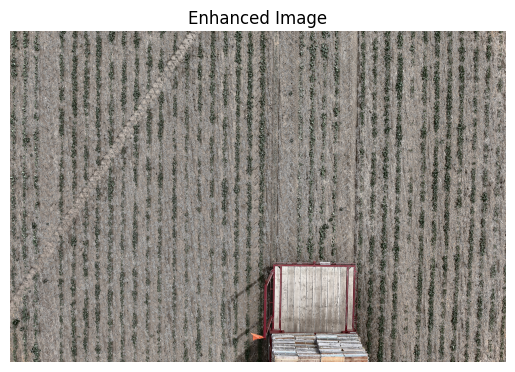

Image cleaned and saved successfully.


In [ ]:
image_path = image_paths[0]  # Change to your image path

# Step 1: Check if the image is corrupt
if is_corrupt(image_path):
    print("Image is corrupt. Skipping.")
else:
    # Step 2: Compute image hash (for duplicate detection if needed)
    image_hash = compute_image_hash(image_path)

    # Step 3: Resize image to a common size (optional: define target size)
    target_size = (512, 512)  # Change as needed
    resize_image(image_path, target_size)

    # Step 4: Enhance the image
    enhanced_img = enhance_image(image_path, target_size)

    # Step 5: Save the enhanced image if processing was successful
    if enhanced_img is not None:
        # cv2.imwrite(image_path, enhanced_img)
        plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
        plt.title("Enhanced Image")
        plt.axis('off')
        plt.show()
        print("Image cleaned and saved successfully.")
    else:
        print("Image enhancement failed.")
